In [2]:
import os, math, sys
from sys import stdout

import numpy as np
import matplotlib.pyplot as plt
import openmm.app  as omm_app
import openmm as omm
import simtk.unit as unit
from tqdm import tqdm
# import mdtraj
import MDAnalysis as mda
from MDAnalysis.analysis import align, rms
from MDAnalysis.analysis.dihedrals import Dihedral
from scipy.interpolate import interp1d

/Users/shashanksule/miniforge3/envs/mdenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/shashanksule/miniforge3/envs/mdenv/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:161: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


In [3]:
from copy import deepcopy

In [4]:
# Indicates whether to run a simulation or not
SIMULATE = False

## 1. Construct an OpenMM system of butane
We set up the MD molecular system in the format/object required by OpenMM, a class called
[System](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.openmm.System.html).

In [6]:
psf = omm_app.CharmmPsfFile('../../data/butane.psf')
pdb = omm_app.PDBFile('../../data/butane.pdb')
topology = psf.topology

In [9]:
params = omm_app.CharmmParameterSet('../../data/top_all35_ethers.rtf',
                                    '../../data/par_all35_ethers.prm')
system = psf.createSystem(params, nonbondedMethod=omm_app.NoCutoff)
with open("../../data/system.xml", 'w') as file_handle:
    file_handle.write(omm.XmlSerializer.serialize(system))
    ## read the OpenMM system of butane
with open("../../data/system.xml", 'r') as file_handle:
    xml = file_handle.read()
system = omm.XmlSerializer.deserialize(xml)

## read psf and pdb file of butane
psf = omm_app.CharmmPsfFile("../../data/butane.psf")
pdb = omm_app.PDBFile('../../data/butane.pdb')
topology = psf.topology

In [9]:
#### setup an OpenMM context
    
## platform
platform = omm.Platform.getPlatformByName('CPU')
    
## integrator
T = 300 * unit.kelvin  ## temperature
fricCoef = 10/unit.picoseconds ## friction coefficient 
stepsize = 2 * unit.femtoseconds ## integration step size
integrator = omm.LangevinMiddleIntegrator(T, fricCoef, stepsize)
simulation = omm_app.Simulation(topology, system, integrator)

# 2a. Pull a trajectory to get positions

In [10]:
mobile = mda.Universe("../../data/butane.psf", "traj_aligned_300K.dcd")
carbons = mobile.atoms[[3, 6, 9, 13]]
theta = Dihedral([carbons]).run().results.angles.flatten()*(np.pi/180.)
trajectory = mobile.trajectory.timeseries(mobile.atoms)


/export/ssule25/miniconda3/envs/ptorch/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/export/ssule25/miniconda3/envs/ptorch/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:326: DeprecationWarning: asel argument to timeseries will be renamed to'atomgroup' in 3.0, see #3911
  warnings.warn(


In [11]:
anti_config_index = np.argmin(np.abs(theta-np.pi))
gauche_60_config_index = np.argmin(np.abs(theta-np.pi/3))
gauche_300_config_index = np.argmin(np.abs(theta+np.pi/3))

In [12]:
anti_config = 0.1*trajectory[:,anti_config_index, :]
gauche_60_config = 0.1*trajectory[:, gauche_60_config_index, :] # multiply by 0.1 because the dcd file writer multiplies positions by 10. 
gauche_300_config = 0.1*trajectory[:, gauche_300_config_index, :] # multiply by 0.1 because the dcd file writer multiplies positions by 10. 


# 2b. Write string method files

In [12]:
def dihedral_angle_numpy(x):
    assert x.shape == (14,3)
    carbons = x[[3,6,9,13],:]
    vectors = carbons[1:,:] - carbons[:-1,:]
    na = np.cross(-vectors[0,:], vectors[1,:])
    nb = np.cross(-vectors[1,:], vectors[2,:])
    xx = np.dot(na, nb)
    xp = np.cross(na,nb)
    yy = np.dot(vectors[1,:].T,xp)/np.linalg.norm(vectors[1,:])
    angle = np.arctan2(yy,xx)
    if angle < 0:
        angle += 2*np.pi
    return angle

In [33]:
def euler_step_string(string, step_size, simulation):
    # get forces along the string
    forces = np.zeros_like(string)
    euler_string = deepcopy(string)
    for i in range(N): 
        simulation.context.setPositions(string[i,:,:])
        state = simulation.context.getState(getForces=True)
        forces[i,:,:] = state.getForces(asNumpy=True).value_in_unit(unit.kilojoules/unit.mole/unit.nanometer)
    euler_string[1:-1, :, :] = string[1:-1, :, :] + step_size*forces[1:-1, :, :]
    return euler_string

def reparameterize(string):
    N = string.shape[0]
    diffs = string - np.concatenate((np.expand_dims(string[0,:,:],0), string[:-1,:,:]), axis=0)
    segment_lengths = np.linalg.norm(diffs, axis=(1,2))
    arc_lengths = np.cumsum(segment_lengths)
    arc_lengths = arc_lengths/arc_lengths[-1]
    interpolator = interp1d(arc_lengths, string, axis=0)
    t = np.linspace(0,1,N)
    return interpolator(t)

In [53]:
total_displacements = []
for i in tqdm(range(1000)): 
    euler_string = euler_step_string(string, 1e-5, simulation)
    new_string = reparameterize(euler_string)
    displacement = np.linalg.norm(string - new_string, axis=(1,2))
    total_displacement = np.linalg.norm(displacement)
    if i % 100 == 0:
        print(f'{total_displacement}')
    string = new_string
    total_displacements.append(total_displacement)

  0%|                                          | 1/1000 [00:00<05:05,  3.27it/s]

5.854487024481237


 10%|████                                    | 101/1000 [00:28<04:10,  3.59it/s]

17220529.660324845


 11%|████▌                                   | 113/1000 [00:31<04:06,  3.59it/s]


KeyboardInterrupt: 

In [18]:
dihedrals_string = []
for i in range(string.shape[0]):
    dihedrals_string.append(dihedral_angle_numpy(string[i,:,:]))

NameError: name 'string' is not defined

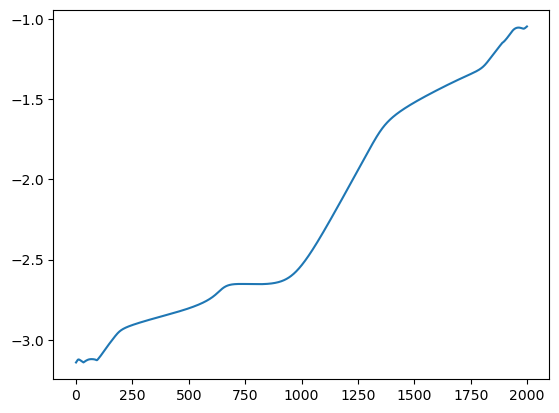

In [38]:
plt.plot(-np.abs(np.array(dihedrals_string)))

In [39]:
# compute arc lengths 
N = string.shape[0]
diffs = string - np.concatenate((np.expand_dims(string[0,:,:],0), string[:-1,:,:]), axis=0)
segment_lengths = np.linalg.norm(diffs, axis=(1,2))
arc_lengths = np.cumsum(segment_lengths)
arc_lengths = arc_lengths/arc_lengths[-1]

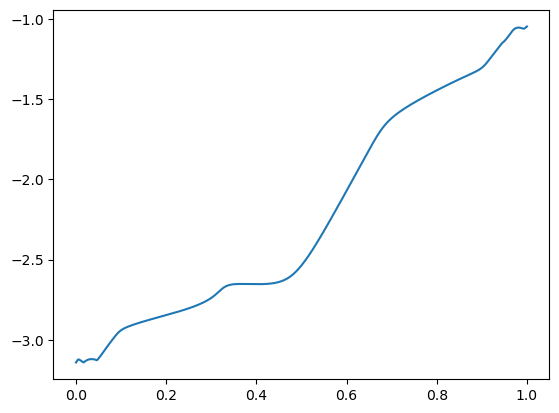

In [40]:
plt.plot(arc_lengths, -np.abs(dihedrals_string))

In [43]:
gauche_60_gauche_300 = np.concatenate((gauche_60_anti[:-1], anti_gauche_300), axis=0)

In [50]:
# parameterize this string by arc length
string = gauche_60_gauche_300
N = string.shape[0]
diffs = string - np.concatenate((np.expand_dims(string[0,:,:],0), string[:-1,:,:]), axis=0)
segment_lengths = np.linalg.norm(diffs, axis=(1,2))
arc_lengths = np.cumsum(segment_lengths)
arc_lengths = arc_lengths/arc_lengths[-1]

In [52]:
np.savez("MEP.npz", MEP=string, arc_lengths=arc_lengths)

# Load previous MEP

In [13]:
MEP_dict = np.load("MEP.npz", allow_pickle=True)
MEP_pts, arc_lengths = MEP_dict['MEP'], MEP_dict['arc_lengths']

In [14]:
dihedrals_string = []
for i in range(MEP_pts.shape[0]):
    dihedrals_string.append(dihedral_angle_numpy(MEP_pts[i,:,:]))

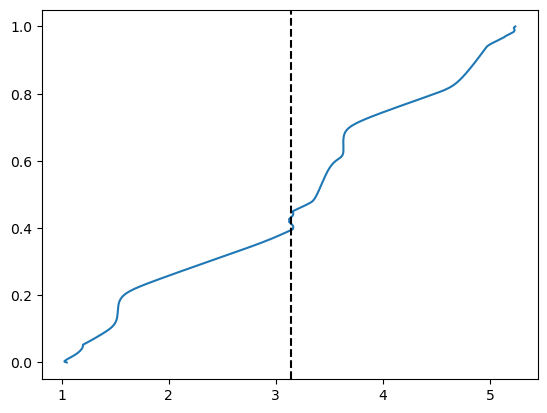

In [15]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(np.array(dihedrals_string), arc_lengths)
ax.axvline(np.pi, linestyle='--', c='k')